In [1]:
import sys
from pathlib import Path

project_root = Path(".").resolve().parent.parent.parent
sys.path.append(str(project_root))

from IPython import display
import pickle as pkl
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import wilcoxon

from context_exploration.model.loader import get_run_directory, load_config
from context_exploration.data.envs import make_env

file_suffix = ""

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

figwidth_half_in = 4.5
figwidth_full_in = 6.47

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "serif"})
plt.rc("text", usetex=True)

plt.rc("text.latex", preamble="\\usepackage{amsmath}")

In [2]:
def build_dataframe(eval_type):
    experiment_dir = project_root.joinpath("experiments", "train_model")
    df_list = []
    for subdir in experiment_dir.iterdir():
        if not subdir.is_dir():
            continue
        if not subdir.name.startswith("model"):
            continue
        for filename in subdir.iterdir():
            if eval_type == "plan":
                if not filename.name.startswith("eval_plan_calib"):
                    continue
            elif eval_type == "pred":
                if not filename.name.startswith("eval_pred_calib"):
                    continue
            else:
                raise ValueError
            df_single = pd.read_pickle(filename)
            df_single["run_id"] = subdir.name

            df_list.append(df_single)
    df = pd.concat(df_list)

    df["run_stem"] = df["run_id"].apply(lambda r: "_".join(r.split("_")[:-1]))
    df["run_seed"] = df["run_id"].apply(lambda r: int(r.split("_")[-1].split("=")[1]))
    df["config"] = (
        df["run_stem"].astype(str) + "_calibrate" + df["calibrate_robot"].astype(str)
    )
    return df

df_plan = build_dataframe(eval_type="plan")
df_pred = build_dataframe(eval_type="pred")

## Do some sanity checks with the data

In [3]:
# Should be '750'
df_pred.groupby("config").size()

config
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse    750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue     750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse     750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue      750
dtype: int64

In [4]:
# Should be '750'
df_plan.groupby("config").size()

config
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse    750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue     750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse     750
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue      750
dtype: int64

In [5]:
group_over_runs = df_plan.groupby(["config", "env_seed"])
group_size = group_over_runs.size()
neq_5 = group_size[group_size != 5]
neq_5  # this should be empty

Series([], dtype: int64)

## Generate comparison matrix with significance test

In [6]:
# Build eval matrix per run (eval_instances x seeds)
eval_matrix_per_run = {}
for config_name in df_plan["config"].unique():
    df_filt = df_plan[df_plan["config"] == config_name][
        ["run_id", "evaluation_idx", "thr_energy_all"]
    ]
    pivot = df_filt.pivot(
        index="evaluation_idx", columns="run_id", values="thr_energy_all"
    )
    pivot_np = pivot.to_numpy()
    eval_matrix_per_run[config_name] = pivot_np

In [7]:
# Compare runs
stats = {}

RUNS = [
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue",
]

gain_med = np.zeros((4, 4))
gain_q20 = np.zeros((4, 4))
gain_q80 = np.zeros((4, 4))
is_significant = np.zeros((4, 4))

for idx_a, run_a in enumerate(RUNS):
    for idx_b, run_b in enumerate(RUNS):

        # Expand evaluation matrix for first run as
        # k, c1
        # k, c1
        # k, c1
        # k, c1
        # k, c1
        # k, c2
        # k, c2
        # ...
        # and for second run as
        # k, c1
        # k, c2
        # k, c3
        # k, c4
        # k, c5
        # k, c1
        # ...

        matrix_a = eval_matrix_per_run[run_a]
        n_seeds = matrix_a.shape[1]
        matrix_a = matrix_a.reshape(-1)
        matrix_a = np.repeat(matrix_a, n_seeds)

        matrix_b = eval_matrix_per_run[run_b]
        matrix_b = matrix_b.reshape(-1)
        matrix_b = np.repeat(matrix_b, n_seeds)

        stats[run_a, run_b] = {
            "q20": np.quantile(matrix_a - matrix_b, q=0.2),
            "med": np.median(matrix_a - matrix_b),
            "q80": np.quantile(matrix_a - matrix_b, q=0.8),
            "mean": np.mean(matrix_a - matrix_b),
        }
        if run_a != run_b:
            stats[run_a, run_b]["pval_less"] = wilcoxon(
                x=matrix_a, y=matrix_b, **{"alternative": "less"}
            )[1]
            stats[run_a, run_b]["pval_greater"] = wilcoxon(
                x=matrix_a, y=matrix_b, **{"alternative": "greater"}
            )[1]
            stats[run_a, run_b]["signif"] = (
                stats[run_a, run_b]["pval_less"] < 0.05
            ) or (stats[run_a, run_b]["pval_greater"] < 0.05)

        gain_med[idx_a, idx_b] = stats[run_a, run_b]["med"]
        gain_q20[idx_a, idx_b] = stats[run_a, run_b]["q20"]
        gain_q80[idx_a, idx_b] = stats[run_a, run_b]["q80"]
        if run_a != run_b:
            is_significant[idx_a, idx_b] = stats[run_a, run_b]["signif"]

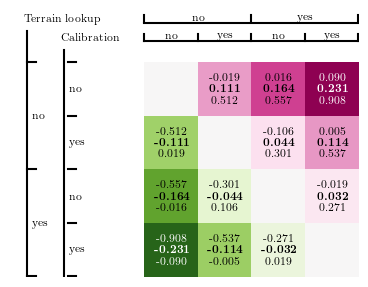

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figwidth_half_in, 3.5))

ax.matshow(gain_med, cmap="PiYG_r")

xoff = 0.35

ax.text(-2.4 - xoff, -1.25, "Terrain lookup")
ax.text(-1.7 - xoff, -0.9, "Calibration")

# Column labels for terrain lookup
ax.text(0.5, -1.25, "no", horizontalalignment="center", verticalalignment="bottom")
ax.text(2.5, -1.25, "yes", horizontalalignment="center", verticalalignment="bottom")

# Row labels for terrain lookup
ax.text(-2.25 - xoff, 0.5, "no", horizontalalignment="left", verticalalignment="center")
ax.text(
    -2.25 - xoff, 2.5, "yes", horizontalalignment="left", verticalalignment="center"
)

for step in range(4):
    # Text
    if step % 2 == 0:
        text = "no"
    else:
        text = "yes"
    ax.text(
        -1.55 - xoff,
        step,
        text,
        horizontalalignment="left",
        verticalalignment="center",
    )
    ax.text(
        step,
        -0.9,
        text,
        horizontalalignment="center",
        verticalalignment="bottom",
    )

for tickloc in range(5):

    # Outer ticks
    if tickloc % 2 == 0:
        ax.axhline(tickloc - 0.51, 0.05, 0.075, color="k")
        ax.axvline(tickloc - 0.51, 0.955, 0.98, color="k")

    # Inner ticks
    ax.axhline(tickloc - 0.51, 0.165, 0.19, color="k")
    ax.axvline(tickloc - 0.51, 0.885, 0.91, color="k")

# Lines for 'Terrain lookup'
ax.axhline(-1.25, 0.385, 1, color="k")
ax.axvline(-2.35 - xoff, 0, 0.92, color="k")

# Lines for 'Calibration'
ax.axhline(-0.9, 0.385, 1, color="k")
ax.axvline(-1.65 - xoff, 0, 0.85, color="k")

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")

# Plot gains
for model_idx_a, model_idx_b in itertools.product(
    range(gain_med.shape[0]), range(gain_med.shape[1])
):
    if model_idx_a == model_idx_b:
        continue
    text_q20 = f"{gain_q20[model_idx_a, model_idx_b]:.3f}"
    text_med = f"{gain_med[model_idx_a, model_idx_b]:.3f}"
    text_q80 = f"{gain_q80[model_idx_a, model_idx_b]:.3f}"

    if is_significant[model_idx_a, model_idx_b]:
        text_med = "\\textbf{" + text_med + "}"
        text_q20 = "{" + text_q20 + "}"
        text_q80 = "{" + text_q80 + "}"

    text = f"{text_q20}\n{text_med}\n{text_q80}"

    # x = column, y = row
    color = "k"
    if model_idx_a == 0 and model_idx_b == 3:
        color = "w"
    if model_idx_a == 3 and model_idx_b == 0:
        color = "w"
    ax.text(
        model_idx_b,
        model_idx_a,
        text,
        horizontalalignment="center",
        verticalalignment="center",
        color=color,
    )

plt.savefig(
    f"generated/unicycle_planning_gain.png",
    bbox_inches="tight",
    pad_inches=0,
)

## Compute final distance to target and failure rate

In [9]:
df_plan["final_dist"] = df_plan["dist"].apply(lambda d: d[-1])
df_plan["fail"] = df_plan["dist"].apply(lambda d: d[-1] > 0.05)

In [10]:
median = df_plan.groupby("config")["final_dist"].median() * 1000
q20 = df_plan.groupby("config")["final_dist"].quantile(q=0.2) * 1000
q80 = df_plan.groupby("config")["final_dist"].quantile(q=0.8) * 1000

df = pd.DataFrame({"q20": q20, "median": median, "q80": q80})
df

,q20,median,q80
config,,,
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse,3.001844,5.185648,8.669601
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue,3.132602,5.233993,7.649175
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse,2.326941,4.220997,6.490192
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue,2.161007,3.853023,5.613965


In [11]:
df.apply(lambda r: f"{r['q20']:.2f} & {r['median']:.2f} & {r['q80']:.2f}", axis=1)

config
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse    3.00 & 5.19 & 8.67
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue     3.13 & 5.23 & 7.65
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse     2.33 & 4.22 & 6.49
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue      2.16 & 3.85 & 5.61
dtype: object

In [12]:
df_plan.groupby("config")["fail"].sum()

config
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse     6
model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue      0
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse     14
model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue       0
Name: fail, dtype: int64

## Prediction evaluation

In [13]:
# Angle difference is signed
df_pred["angle_diff"] = df_pred["angle_diff"].apply(lambda x: np.abs(x))
# degrees
df_pred["angle_diff"] = 180 * df_pred["angle_diff"] / np.pi


def agg_mean(x):
    return np.stack(x.values).mean(axis=0)


def agg_quant(x, q):
    return np.quantile(np.stack(x.values), q, axis=0)


agg_dict = {}
for base_measure in ["l2_pos", "l2_vel", "angle_diff"]:
    agg_dict[base_measure + "_mean"] = pd.NamedAgg(
        column=base_measure, aggfunc=agg_mean
    )
    agg_dict[base_measure + "_q20"] = pd.NamedAgg(
        column=base_measure, aggfunc=lambda x: agg_quant(x, 0.2)
    )
    agg_dict[base_measure + "_q80"] = pd.NamedAgg(
        column=base_measure, aggfunc=lambda x: agg_quant(x, 0.8)
    )

df_pred_agg = df_pred.groupby(["config"]).agg(**agg_dict)

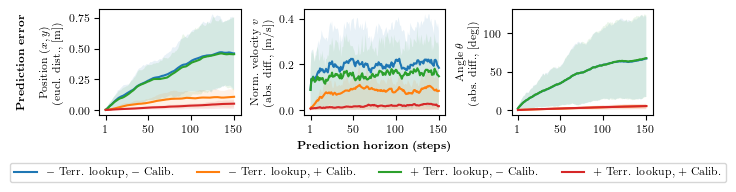

In [14]:
LABEL_DICT = {
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateFalse": "$-$ Terr. lookup, $-$ Calib.",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=False_calibrateTrue": "$-$ Terr. lookup, $+$ Calib.",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateFalse": "$+$ Terr. lookup, $-$ Calib.",
    "model_env=unicycle_robotvary_terrainpatches_uselocalctx=True_calibrateTrue": "$+$ Terr. lookup, $+$ Calib.",
}
fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=3,
    layout="constrained",
    figsize=(figwidth_full_in, 1.5),
)
for ax in ax_arr:
    ax.set_xticks([1, 50, 100, 150])

for col, base_measure in enumerate(["l2_pos", "l2_vel", "angle_diff"]):
    ax = ax_arr[col]

    for variant_name in LABEL_DICT.keys():
        row = df_pred_agg.loc[variant_name]
        x = np.arange(1, len(row[f"{base_measure}_mean"]))
        ax.plot(x, row[f"{base_measure}_mean"][1:], label=LABEL_DICT[variant_name])
        ax.fill_between(
            x, row[f"{base_measure}_q20"][1:], row[f"{base_measure}_q80"][1:], alpha=0.1
        )

h, l = ax_arr[0].get_legend_handles_labels()
fig.legend(
    loc="lower center",
    handles=h,
    labels=l,
    bbox_to_anchor=(0.55, -0.215),
    ncol=4,
)
ax_arr[0].set_ylabel(
    "\\textbf{Prediction error}\n\nPosition $(x, y)$ \n(eucl. dist., [m])"
)
ax_arr[1].set_ylabel("Norm. velocity $v$ \n(abs. diff., [m/s])")
ax_arr[2].set_ylabel("Angle $\\theta$ \n(abs. diff., [deg])")
ax_arr[1].set_xlabel("\\textbf{Prediction horizon (steps)}")

plt.savefig(
    f"generated/unicycle_prediction.png", bbox_inches="tight", pad_inches=0
)

In [15]:
from context_exploration.data.envs import make_env

ENV_NAME = "unicycle_robotvary_terrainpatches"

def plot_terrain(ax, df, eval_idx):
    context_seed = df.loc[eval_idx].context_seed
    env_name = "_".join(df.loc[eval_idx].config.split("=")[1].split("_")[:-1])
    kwarg_updates = {
        "reset_split": "test",
        # This parameter need to be read from the run config,
        # but we don't need it now
        "max_duration": 1,
    }
    env = make_env(env_name, **kwarg_updates)
    env.initialize_context(context_seed)
    ims = env.plot_friction(ax, alpha=0.5)
    env.release_context()
    ax.axis("off")
    return ims


def plot_obs(ax, df, eval_idx, plot_start_end):
    obs = df.loc[eval_idx].obs_arr
    h = ax.plot(obs[:, 0], obs[:, 1], linewidth=0.8)
    ax.scatter(obs[:, 0], obs[:, 1], s=4)

    if plot_start_end:
        init_xy = df.loc[eval_idx].initial_state[:2]
        target_xy = df.loc[eval_idx].target_state[:2]
        ax.scatter(*init_xy, color="white", marker="x", s=200,)
        ax.scatter(*target_xy, color="black", marker="x", s=200,)

    return h

$-$ Terr. lookup, $-$ Calib. & 4.08 & 7.82
$-$ Terr. lookup, $+$ Calib. & 3.47 & 4.89
$+$ Terr. lookup, $-$ Calib. & 2.01 & 4.57
$+$ Terr. lookup, $+$ Calib. & 2.02 & 5.55
$-$ Terr. lookup, $-$ Calib. & 3.96 & 2.69
$-$ Terr. lookup, $+$ Calib. & 2.78 & 4.87
$+$ Terr. lookup, $-$ Calib. & 1.88 & 5.14
$+$ Terr. lookup, $+$ Calib. & 1.43 & 6.66


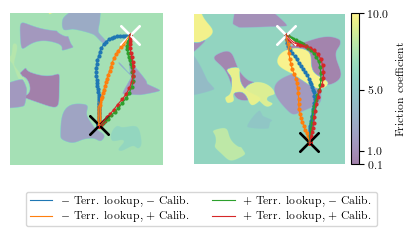

In [16]:
# interesting evaluation indices: 38, 112

fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(figwidth_half_in, 2.4),
    width_ratios=[1, 1.08],
)


for col, eval_idx in enumerate([38, 112]):
    ax = ax_arr.flatten()[col]

    labels = []
    handles = []

    for idx, variant in enumerate(LABEL_DICT.keys()):
        run_seed = 1
        df_filt = df_plan[
            (df_plan["run_seed"] == run_seed) & (df_plan["config"] == variant)
        ]
        df_filt = df_filt.set_index("evaluation_idx")

        ctrl_energy = df_filt["thr_energy_all"].loc[eval_idx]
        goal_dist = df_filt["dist"].loc[eval_idx][-1] * 1000

        print(f"{LABEL_DICT[variant]} & {ctrl_energy:.2f} & {goal_dist:.2f}")
        if idx == 0:
            trr = plot_terrain(ax, df_filt, eval_idx)
        (h,) = plot_obs(ax, df_filt, eval_idx, plot_start_end=True)
        handles.append(h)
        labels.append(LABEL_DICT[variant])

    if col in [1, 3]:
        fig.colorbar(
            trr,
            ax=ax,
            ticks=[0.1, 1, 5, 10],
            fraction=0.046,
            pad=0.04,
            label="Friction coefficient",
        )
        fig.legend(
            handles,
            labels,
            ncols=2,
            loc="lower center",
            bbox_to_anchor=(0.55, -0.1),
        )

plt.savefig(
    f"generated/unicycle_planning_examples.png",
    bbox_inches="tight",
    pad_inches=0,
)

$-$ Terr. lookup, $-$ Calib. & 15.26 & 177.51
$-$ Terr. lookup, $+$ Calib. & 12.20 & 14.89
$+$ Terr. lookup, $-$ Calib. & 15.75 & 184.52
$+$ Terr. lookup, $+$ Calib. & 7.25 & 6.49
$-$ Terr. lookup, $-$ Calib. & 11.31 & 74.01
$-$ Terr. lookup, $+$ Calib. & 5.37 & 9.03
$+$ Terr. lookup, $-$ Calib. & 11.47 & 60.91
$+$ Terr. lookup, $+$ Calib. & 2.49 & 5.12
$-$ Terr. lookup, $-$ Calib. & 15.26 & 177.51
$-$ Terr. lookup, $+$ Calib. & 12.20 & 14.89
$+$ Terr. lookup, $-$ Calib. & 15.75 & 184.52
$+$ Terr. lookup, $+$ Calib. & 7.25 & 6.49
$-$ Terr. lookup, $-$ Calib. & 11.31 & 74.01
$-$ Terr. lookup, $+$ Calib. & 5.37 & 9.03
$+$ Terr. lookup, $-$ Calib. & 11.47 & 60.91
$+$ Terr. lookup, $+$ Calib. & 2.49 & 5.12


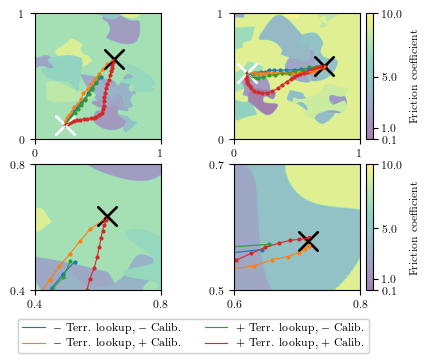

In [17]:
# Failure cases
fig, ax_arr = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(figwidth_half_in, 3.6),
    width_ratios=[1, 1.08],
)

for row in [0, 1]:
    for col, eval_idx in enumerate([163, 145]):
        ax = ax_arr[row, col]

        labels = []
        handles = []

        for idx, variant in enumerate(LABEL_DICT.keys()):
            run_seed = 5 if eval_idx == 145 else 1
            df_filt = df_plan[
                (df_plan["run_seed"] == run_seed) & (df_plan["config"] == variant)
            ]
            df_filt = df_filt.set_index("evaluation_idx")

            ctrl_energy = df_filt["thr_energy_all"].loc[eval_idx]
            goal = df_filt["target_state"].loc[eval_idx][:2]
            goal_dist = df_filt["dist"].loc[eval_idx][-1] * 1000

            print(f"{LABEL_DICT[variant]} & {ctrl_energy:.2f} & {goal_dist:.2f}")
            if idx == 0:
                trr = plot_terrain(ax, df_filt, eval_idx)
            (h,) = plot_obs(ax, df_filt, eval_idx, plot_start_end=True)
            handles.append(h)
            labels.append(LABEL_DICT[variant])

        if col in [1, 3]:
            fig.colorbar(
                trr,
                ax=ax,
                ticks=[0.1, 1, 5, 10],
                fraction=0.046,
                pad=0.04,
                label="Friction coefficient",
            )
            fig.legend(
                handles,
                labels,
                ncols=2,
                loc="lower center",
                bbox_to_anchor=(
                    0.5,
                    -0.08,
                ),
            )

        if row == 0:
            ax.axis("on")
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
        if row == 1:
            ax.axis("on")
            if col == 0:
                ax.set_xlim(round(goal[0] - 0.2, 1), round(goal[0] + 0.2, 1))
                ax.set_ylim(round(goal[1] - 0.2, 1), round(goal[1] + 0.2, 1))
            elif col == 1:
                ax.set_xlim(round(goal[0] - 0.1, 1), round(goal[0] + 0.1, 1))
                ax.set_ylim(round(goal[1] - 0.1, 1), round(goal[1] + 0.1, 1))
            ax.set_xticks(ax.get_xlim())
            ax.set_yticks(ax.get_ylim())

plt.subplots_adjust(wspace=0.3)
plt.savefig(
    f"generated/unicycle_planning_fail.png",
    bbox_inches="tight",
    pad_inches=0,
)

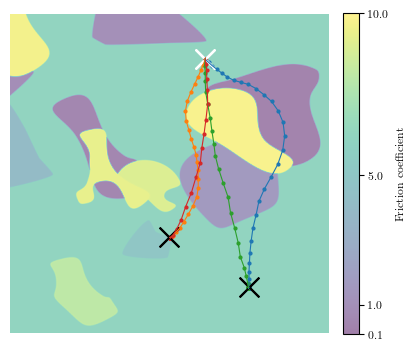

In [18]:
# Teaser figure

teaser_data = pd.read_pickle("../unicycle/unicycle_teaser_data.pkl")

teaser_data["run_stem"] = teaser_data["run_id"].apply(
    lambda r: "_".join(r.split("_")[:-1])
)
teaser_data["run_seed"] = teaser_data["run_id"].apply(
    lambda r: int(r.split("_")[-1].split("=")[1])
)
teaser_data["config"] = (
    teaser_data["run_stem"].astype(str)
    + "_calibrate"
    + teaser_data["calibrate_robot"].astype(str)
)

teaser_data.set_index("evaluation_idx")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figwidth_half_in, figwidth_half_in))
trr = plot_terrain(ax, teaser_data, 0)
plot_obs(ax, teaser_data, 0, plot_start_end=True)
plot_obs(ax, teaser_data, 1, plot_start_end=True)
plot_obs(ax, teaser_data, 2, plot_start_end=True)
plot_obs(ax, teaser_data, 3, plot_start_end=True)

fig.colorbar(
    trr,
    ax=ax,
    ticks=[0.1, 1, 5, 10],
    fraction=0.046,
    pad=0.04,
    label="Friction coefficient",
)
plt.savefig(
    f"generated/unicycle_planning_teaser.png",
    bbox_inches="tight",
    pad_inches=0,
)